In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import random

In [12]:
# Filepath to algorithm outputs
ind_time_filepath = "../output_data_au/Simulation_Results_2023-08-15T100831.821222/individual_time_point_data.csv"

# Filepath to raw data
raw_data = "../PROM-RulesBasedAlgorithmData_R2.0.xlsx"

In [13]:
# Mapping domain codes to more readable names
domain_code_to_name = {"ui_domain" : "Urinary Incontinence Domain",
                      "sf_domain" : "Sexual Function Domain",
                       "uio_domain" : "Urinary Obstruction Domain",
                       "bf_domain" : "Bowel Function Domain",
                       "hf_domain" : "Hormonal Function Domain",
                       "q6d" : "Blood Stools Question"
                      }

In [14]:
# Read all files from path into dataframes

unfiltered_ind_time_df = pd.read_csv(ind_time_filepath)
print(len(unfiltered_ind_time_df))
print(unfiltered_ind_time_df.head())

unfiltered_raw_data_df = pd.read_excel(raw_data, sheet_name="PROM-RulesBasedAlgorithmData_R2")
print(len(unfiltered_raw_data_df))
print(unfiltered_raw_data_df.head())

16319
  Patient Identifier           Time Point Urinary Incontinence Domain State  \
0  15970_370765.json  2019-04-09 00:00:00                            Normal   
1  15970_413565.json  2020-12-05 00:00:00                          Abnormal   
2   9204_198609.json  2015-05-12 00:00:00                            Normal   
3   9204_235725.json  2015-11-04 00:00:00                            Normal   
4   9204_279366.json  2016-08-29 22:25:00                            Normal   

  Urinary Irritation/Obstruction Domain State Bowel Function Domain State  \
0                     Clinically Urgent Alert                      Normal   
1                     Clinically Urgent Alert                      Normal   
2                                      Normal                      Normal   
3                                      Normal                    Abnormal   
4                     Clinically Urgent Alert                      Normal   

  Q6d State Sexual Function Domain State Hormonal Functi

# Cleaning

Remove participants with missing age data or null values for questionnaire responses

In [15]:
# Remove participants with missing age data
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['AgeAtDx'].isin(list(range(0, 100))))]

# Format as [(participant_id, report_id)]
participant_df = list(participant_df['CapstudiesID'])
report_id_data = unfiltered_raw_data_df.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
keep_ids = [(participant_id, report_id) for participant_id, lo_report_id in report_id_data.items() for report_id in lo_report_id if participant_id in participant_df]

# Filter raw data
filtered_raw_data_df1 = unfiltered_raw_data_df[(unfiltered_raw_data_df[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df1 = unfiltered_ind_time_df[(unfiltered_ind_time_df['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

participant_count0 = len(set(unfiltered_raw_data_df['CapstudiesID']))
participant_count1 = len(set(filtered_raw_data_df1['CapstudiesID']))
print(f"{participant_count0} -> {participant_count1} participants")
print(f"{len(unfiltered_raw_data_df)} -> {len(filtered_raw_data_df1)} alerts")

5147 -> 4935 participants
16319 -> 15717 alerts


In [16]:
# Remove participants with null values for questionnaire responses
m=filtered_ind_time_df1.isnull().sum(axis=1)
m=m[~m.isin([0])].index.unique()

report_id_data = unfiltered_raw_data_df.loc[m].groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
keep_ids = [(participant_id, report_id) for participant_id, lo_report_id in report_id_data.items() for report_id in lo_report_id]

# Filter raw data
filtered_raw_data_df2 = filtered_raw_data_df1[(filtered_raw_data_df1[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df2 = filtered_ind_time_df1[(filtered_ind_time_df1['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

participant_count2 = len(set(filtered_raw_data_df2['CapstudiesID']))
print(f"{participant_count1} -> {participant_count2} participants")
print(f"{len(filtered_ind_time_df1)} -> {len(filtered_ind_time_df2)} alerts")

4935 -> 4933 participants
15717 -> 15127 alerts


In [17]:
# keep participants with at least 4 reports
report_id_data = filtered_raw_data_df2.groupby('CapstudiesID')['PROAnswerSetID'].apply(list).to_dict()
interval_data = filtered_raw_data_df2.groupby('CapstudiesID')['Interval'].apply(list).to_dict()

keep_ids = [] # [(patient_id, report_id)]
for id in report_id_data.keys():
    if len(interval_data[id]) >= 4 and len(interval_data[id]) == len(list(set(interval_data[id]))):
        to_keep = list(zip(report_id_data[id], interval_data[id]))
        to_keep = sorted(to_keep, key=lambda x: x[1]) # sort by interval
        keep_ids += [(id, x[0]) for x in to_keep[:4]] # keep first 4 reports

# Filter raw data
filtered_raw_data_df3 = filtered_raw_data_df2[(filtered_raw_data_df2[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(keep_ids))]

# Filter alg output data
filtered_ind_time_df3 = filtered_ind_time_df2[(filtered_ind_time_df2['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in keep_ids]))]

participant_count3 = len(set(filtered_raw_data_df3['CapstudiesID']))
print(f"{participant_count2} -> {participant_count3} participants")
print(f"{len(filtered_ind_time_df2)} -> {len(filtered_ind_time_df3)} alerts")

4933 -> 1412 participants
15127 -> 5648 alerts


# Breakdown After Cleaning

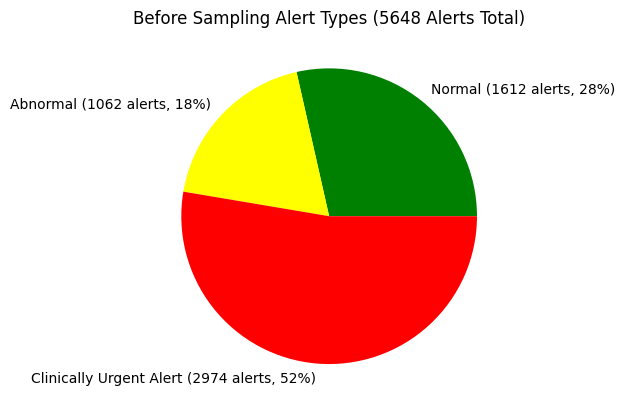

In [18]:
# Look at the frequency for the different types of alerts (normal, abnormal, clinically urgent)
labels = ["Normal", "Abnormal", "Clinically Urgent Alert"]
alert_counts = filtered_ind_time_df3['Final Alert State'].value_counts()
values = [alert_counts[label] for label in labels]
plt.pie(values, labels = [f"{label} ({alert_counts[label]} alerts, {int(100*alert_counts[label]/sum(values))}%)" for label in labels], colors=["green","yellow","red"])
plt.title(f"Before Sampling Alert Types ({sum(values)} Alerts Total)")
plt.show()

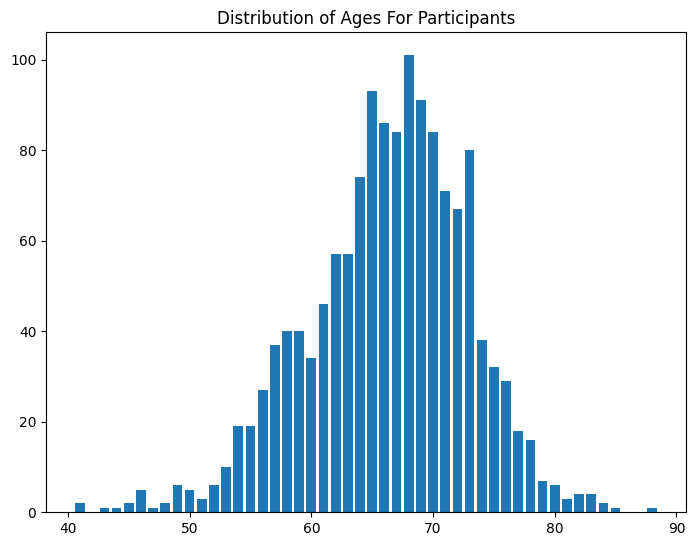

In [19]:
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['CapstudiesID'].isin(set([id[0] for id in keep_ids])))]

age_counts = participant_df['AgeAtDx'].value_counts().to_dict()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ages = age_counts.keys()
counts = [age_counts[age] for age in ages]
ax.bar(ages,counts)
ax.set_title('Distribution of Ages For Participants')
plt.show()

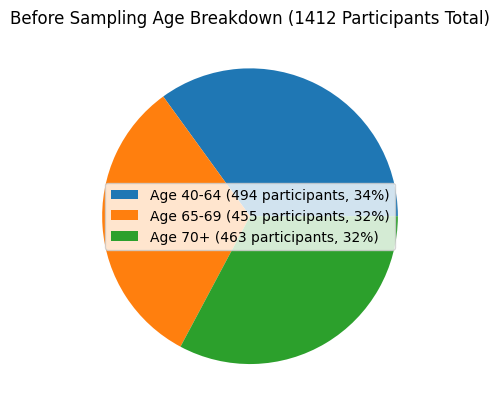

In [20]:
age_groups = {"40-64": 0, "65-69": 0, "70+": 0}
for age in age_counts.keys():
    if age < 65:
        age_groups["40-64"] += age_counts[age]
    elif age < 70:
        age_groups["65-69"] += age_counts[age]
    else:
        age_groups["70+"] += age_counts[age]
labels = sorted(age_groups.keys())
values = [age_groups[group] for group in labels]
labels = [f"Age {group} ({age_groups[group]} participants, {int(100*age_groups[group]/sum(values))}%)" for group in labels]
plt.pie(values)
plt.legend(labels)
plt.title(f"Before Sampling Age Breakdown ({sum(values)} Participants Total)")
plt.show()

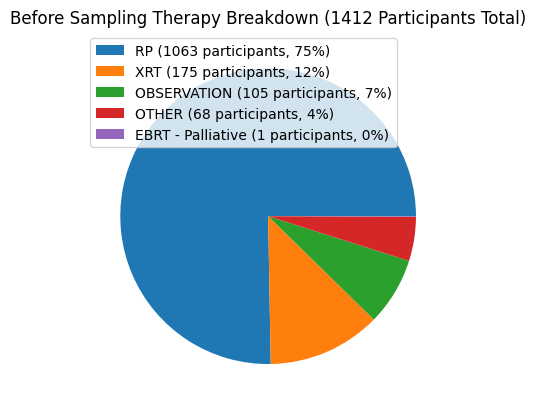

In [21]:
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['CapstudiesID'].isin(set([id[0] for id in keep_ids])))]

therapy_counts = participant_df['iTreatment'].value_counts().to_dict()
# # Not enough data for the following:
# therapy_counts.pop("OTHER")
# therapy_counts.pop("EBRT - Palliative")

labels = list(therapy_counts.keys())
values = [therapy_counts[label] for label in labels]
labels = [f"{tx} ({therapy_counts[tx]} participants, {int(100*therapy_counts[tx]/sum(values))}%)" for tx in labels]
plt.pie(values)
plt.legend(labels)
plt.title(f"Before Sampling Therapy Breakdown ({sum(values)} Participants Total)")
plt.show()

# Sampling

In [22]:
sample_percent = 10 

sampled_participants = random.sample(list(set([id[0] for id in keep_ids])), int(participant_count3/sample_percent))
sampled_ids = [id for id in keep_ids if id[0] in sampled_participants]
# Filter raw data
sampled_raw_data_df = filtered_raw_data_df3[(filtered_raw_data_df3[['CapstudiesID', 'PROAnswerSetID']].apply(tuple, axis=1).isin(sampled_ids))]

# Filter alg output data
sampled_ind_time_df = filtered_ind_time_df3[(filtered_ind_time_df3['Patient Identifier'].isin([f"{id[0]}_{id[1]}.json" for id in sampled_ids]))]

sampled_participant_count = len(set(sampled_raw_data_df['CapstudiesID']))
print(f"{participant_count3} -> {sampled_participant_count} participants")
print(f"{len(filtered_ind_time_df3)} -> {len(sampled_ind_time_df)} alerts")

1412 -> 141 participants
5648 -> 564 alerts


# Breakdown After Sampling

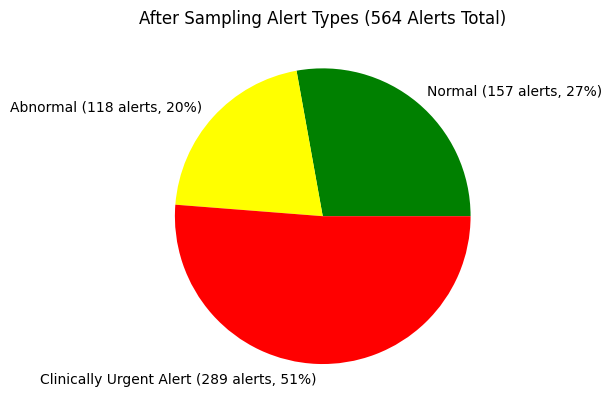

In [23]:
# Look at the frequency for the different types of alerts (normal, abnormal, clinically urgent)
labels = ["Normal", "Abnormal", "Clinically Urgent Alert"]
alert_counts = sampled_ind_time_df['Final Alert State'].value_counts()
values = [alert_counts[label] for label in labels]
plt.pie(values, labels = [f"{label} ({alert_counts[label]} alerts, {int(100*alert_counts[label]/sum(values))}%)" for label in labels], colors=["green","yellow","red"])
plt.title(f"After Sampling Alert Types ({sum(values)} Alerts Total)")
plt.show()

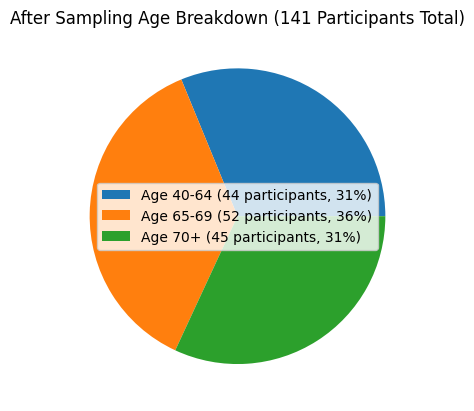

In [24]:
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['CapstudiesID'].isin(set([id[0] for id in sampled_ids])))]

age_counts = participant_df['AgeAtDx'].value_counts().to_dict()
age_groups = {"40-64": 0, "65-69": 0, "70+": 0}
for age in age_counts.keys():
    if age < 65:
        age_groups["40-64"] += age_counts[age]
    elif age < 70:
        age_groups["65-69"] += age_counts[age]
    else:
        age_groups["70+"] += age_counts[age]
labels = sorted(age_groups.keys())
values = [age_groups[group] for group in labels]
labels = [f"Age {group} ({age_groups[group]} participants, {int(100*age_groups[group]/sum(values))}%)" for group in labels]
plt.pie(values)
plt.legend(labels)
plt.title(f"After Sampling Age Breakdown ({sum(values)} Participants Total)")
plt.show()

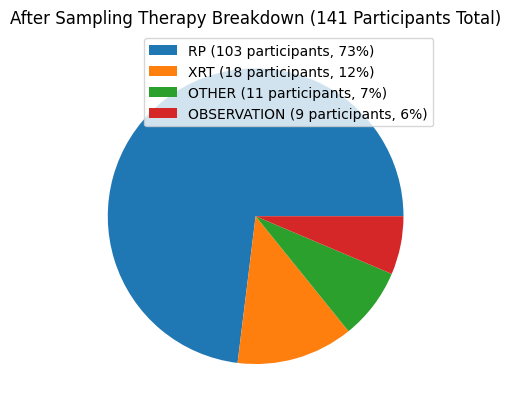

In [25]:
participant_df = pd.read_excel(raw_data, sheet_name="Person")
participant_df = participant_df[(participant_df['CapstudiesID'].isin(set([id[0] for id in sampled_ids])))]

therapy_counts = participant_df['iTreatment'].value_counts().to_dict()
# # Not enough data for the following:
# therapy_counts.pop("OTHER")
# therapy_counts.pop("EBRT - Palliative")

labels = list(therapy_counts.keys())
values = [therapy_counts[label] for label in labels]
labels = [f"{tx} ({therapy_counts[tx]} participants, {int(100*therapy_counts[tx]/sum(values))}%)" for tx in labels]
plt.pie(values)
plt.legend(labels)
plt.title(f"After Sampling Therapy Breakdown ({sum(values)} Participants Total)")
plt.show()

# Output Sampled Dataset

In [26]:
with pd.ExcelWriter('../SampledSAPCRData.xlsx') as writer:
    participant_df.to_excel(writer, sheet_name='Person')
    sampled_raw_data_df.to_excel(writer, sheet_name='PROM-RulesBasedAlgorithmData_R2')